# Analysing performance and solutions as time constants change

This builds on [Optimizing-Membrane-Time-Constant.ipynb](./Optimizing-Membrane-Time-Constant.ipynb) and [3-Starting-Notebook.ipynb](./3-Starting-Notebook.ipynb), see those notebooks for background.

## Imports and setup

In [121]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

## Data generation

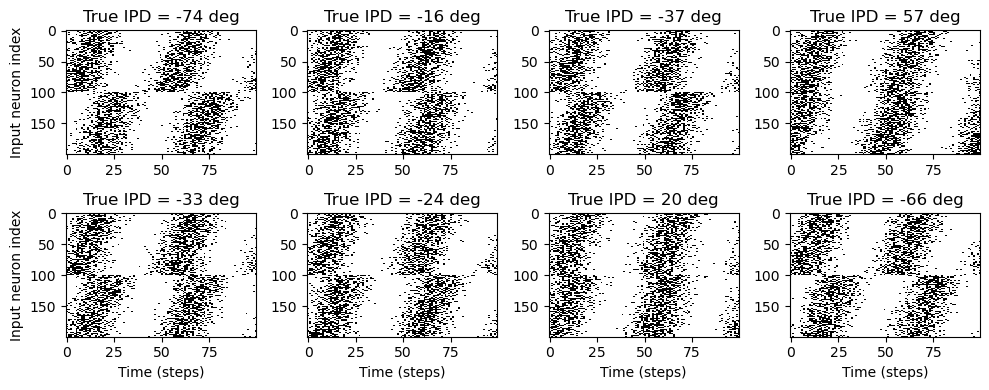

In [22]:
class ITDDataset(torch.utils.data.Dataset):
    def __init__(self,
                 num_samples,
                 dt=1*ms,             # large time step to make simulations run faster for tutorial
                 anf_per_ear=100,     # repeats of each ear with independent noise
                 envelope_power=2,    # higher values make sharper envelopes, easier
                 rate_max=600*Hz,     # maximum Poisson firing rate
                 f=20*Hz,             # stimulus frequency
                 duration=.1*second,  # stimulus duration
                 num_classes=180//15, # number of IPD classes for discretisation
                 batch_size=128,
                 shuffle=True,
                 ):
        self.num_samples = num_samples
        self.dt = dt
        self.anf_per_ear = anf_per_ear
        self.envelope_power = envelope_power
        self.rate_max = rate_max
        self.f = f
        self.duration = duration
        self.duration_steps = int(np.round(duration/dt))
        self.input_size = 2*anf_per_ear
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ipd, self.spikes = self.random_ipd_input_signal()
        self.data_loader = torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=shuffle)

    # Generate an input signal (spike array) from array of true IPDs
    def input_signal(self, ipd):
        num_samples = len(ipd)
        T = np.arange(self.duration_steps)*self.dt # array of times
        phi = 2*np.pi*(self.f*T+np.random.rand()) # array of phases corresponding to those times with random offset
        # each point in the array will have a different phase based on which ear it is
        # and its delay
        theta = np.zeros((num_samples, self.duration_steps, 2*self.anf_per_ear))
        # for each ear, we have anf_per_ear different phase delays from to pi/2 so
        # that the differences between the two ears can cover the full range from -pi/2 to pi/2
        phase_delays = np.linspace(0, np.pi/2, self.anf_per_ear)
        # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
        # but implements the idea in the text above.
        theta[:, :, :self.anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
        theta[:, :, self.anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
        # now generate Poisson spikes at the given firing rate as in the previous notebook
        spikes = np.random.rand(num_samples, self.duration_steps, 2*self.anf_per_ear)<self.rate_max*self.dt*(0.5*(1+np.sin(theta)))**self.envelope_power
        return spikes

    # Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    def random_ipd_input_signal(self):
        ipd = np.random.rand(self.num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
        spikes = self.input_signal(ipd)
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
        return ipd, spikes
    
    def discretise(self, ipds):
        return ((ipds+np.pi/2)*self.num_classes/np.pi).long() # assumes input is tensor

    def continuise(self, ipd_indices): # convert indices back to IPD midpoints
        return (ipd_indices+0.5)/self.num_classes*np.pi-np.pi/2    
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.spikes[idx, :, :], self.discretise(self.ipd[idx])
    
    def visualise(self, w=4, h=2):
        N = w*h
        # Plot a few just to show how it looks
        spikes = self.spikes.cpu()
        plt.figure(figsize=(10, 4), dpi=100)
        for i in range(N):
            plt.subplot(h, w, i+1)
            plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            plt.title(f'True IPD = {int(self.ipd[i]*180/np.pi)} deg')
            if i>=4:
                plt.xlabel('Time (steps)')
            if i%4==0:
                plt.ylabel('Input neuron index')
        plt.tight_layout()


train_data = ITDDataset(num_samples=128*128, batch_size=128)
test_data = ITDDataset(num_samples=32*128, batch_size=128)
test_data.visualise()

## Model

### Surrogate gradient function

In [42]:
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        beta = 5
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

### Spiking neural network

In [106]:
class ITDNet(nn.Module):
    def __init__(self, dataset, num_hidden=30, tau=20*ms, dt=1*ms):
        super(ITDNet, self).__init__()
        self.input_size = dataset.input_size
        self.num_classes = dataset.num_classes
        self.num_hidden = num_hidden
        self.tau = tau
        self.dt = dt
        self.init_weight_matrices()

    # Weights and uniform weight initialisation
    def init_weight_matrices(self):
        # Input to hidden layer
        self.W_ih = nn.Parameter(torch.empty((self.input_size, self.num_hidden), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_ih)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.W_ih, -bound, bound)
        # Hidden layer to output
        self.W_ho = nn.Parameter(torch.empty((self.num_hidden, self.num_classes), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_ho)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.W_ho, -bound, bound)
        return self.W_ih, self.W_ho
        
    def forward(self, input_spikes, apply_softmax=True):
        batch_size, duration_steps, input_size = input_spikes.shape
        if input_size!=self.input_size:
            raise ValueError(f"Expected input size {self.input_size} but got {input_size}")
        # First layer: input to hidden
        v = torch.zeros((batch_size, self.num_hidden), device=device, dtype=dtype)
        s = torch.zeros((batch_size, self.num_hidden), device=device, dtype=dtype)
        s_rec = [s]
        h = torch.einsum("abc,cd->abd", (input_spikes, self.W_ih))
        alpha = np.exp(-self.dt/self.tau)
        for t in range(duration_steps - 1):
            new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
            s = spike_fn(v-1) # threshold of 1
            v = new_v
            s_rec.append(s)
        s_rec = torch.stack(s_rec, dim=1)
        # Second layer: hidden to output
        v = torch.zeros((batch_size, self.num_classes), device=device, dtype=dtype)
        s = torch.zeros((batch_size, self.num_classes), device=device, dtype=dtype)
        v_rec = [v]
        h = torch.einsum("abc,cd->abd", (s_rec, self.W_ho))
        alpha = np.exp(-self.dt/self.tau)
        for t in range(duration_steps - 1):
            v = alpha*v + h[:, t, :]
            v_rec.append(v)
        v_rec = torch.stack(v_rec, dim=1)
        # Return softmax of mean recorded membrane potential of output
        m = torch.mean(v_rec, 1)  # Mean across time dimension
        if apply_softmax:
            log_softmax_fn = nn.LogSoftmax(dim=1)
            m = log_softmax_fn(m)
        return m

    def train(self, nb_epochs=10, lr=0.01, pbar=None):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.NLLLoss()
        # training loop
        loss_hist = []
        if pbar is None:
            print(f"Want loss for epoch 1 to be about {-np.log(1/train_data.num_classes):.2f}, multiply m by constant to get this")
            pbar = tqdm(total=nb_epochs)
            close_pbar = True
        else:
            close_pbar = False
        for e in range(nb_epochs):
            local_loss = []
            for spikes, ipds in train_data.data_loader:
                # Run network
                output = self(spikes)
                loss = loss_fn(output, ipds)
                local_loss.append(loss.item())
                # Update gradients
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_hist.append(np.mean(local_loss))
            pbar.update(1)
            pbar.set_postfix(epoch=e, loss=loss_hist[-1])
        if close_pbar:
            pbar.close()
        return loss_hist

## Training

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this


  0%|          | 0/30 [00:00<?, ?it/s]

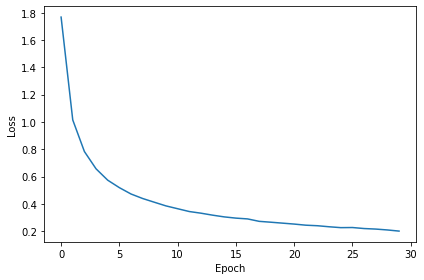

In [133]:
net = ITDNet(train_data, tau=2*ms)
loss_hist = net.train(nb_epochs=10)
# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

## Analysis of trained network

In [128]:
class AnalysisResults:
    def __init__(self, model, dataset, label):
        self.model = model
        self.dataset = dataset
        self.label = label

        # compute results on test dataset
        all_output = []
        all_ipd_idx_true = []
        for spikes, ipds in dataset.data_loader:
            with torch.no_grad():
                output = model(spikes, apply_softmax=False)
            all_output.append(output)
            all_ipd_idx_true.append(ipds)
        self.all_output = all_output = torch.cat(all_output, 0).detach().cpu().numpy()
        self.all_ipd_idx_est = all_ipd_idx_est = np.argmax(all_output, 1)
        self.all_ipd_idx_true = all_ipd_idx_true = torch.cat(all_ipd_idx_true, 0).detach().cpu().numpy()
        self.all_ipd_est = all_ipd_est = dataset.continuise(all_ipd_idx_est)
        self.all_ipd_true = all_ipd_true = dataset.continuise(all_ipd_idx_true)

        # confusion matrix
        self.confusion = confusion = np.zeros((dataset.num_classes, dataset.num_classes))
        for i, j in zip(all_ipd_idx_true, all_ipd_idx_est):
            confusion[j, i] += 1
        confusion /= np.sum(confusion, axis=0)[np.newaxis, :]

        # tuning curves
        self.tuning_curve_mean = tuning_curve_mean = np.zeros((dataset.num_classes, dataset.num_classes))
        self.tuning_curve_std = tuning_curve_std = np.zeros((dataset.num_classes, dataset.num_classes))
        for i in range(dataset.num_classes):
            o = all_output[all_ipd_idx_true==i, :]
            tuning_curve_mean[i, :] = np.mean(o, axis=0)
            tuning_curve_std[i, :] = np.std(o, axis=0)

        # accuracy
        self.accuracy = ((all_ipd_idx_est==all_ipd_idx_true)*1.0).mean()
        self.mean_abs_error_deg = np.mean(abs(all_ipd_true-all_ipd_est)*180/np.pi)

    def print_text(self):
        print(f"Accuracy on {self.label} set = {self.accuracy*100:.1f}%, mean absolute error = {self.mean_abs_error_deg:.1f} deg")
        return self

    def plot_histograms(self):
        plt.hist(self.all_ipd_true*180/np.pi, bins=self.dataset.num_classes, label='True', alpha=0.8)
        plt.hist(self.all_ipd_est*180/np.pi, bins=self.dataset.num_classes, label='Estimated', alpha=0.8)
        plt.xlabel("IPD")
        plt.yticks([])
        plt.legend(loc='best')
        plt.title(self.label)

    def plot_confusion(self):
        plt.imshow(self.confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
        plt.xlabel('True IPD')
        plt.ylabel('Estimated IPD')
        plt.title(f'Confusion matrix ({self.label})')

    def plot_tuning_curves(self, fig=None, c='k', label=None):
        if label is None:
            label = self.label
        if fig is None:
            plt.figure(figsize=(12, 6), dpi=80)
        else:
            plt.figure(fig)
        for i in range(self.dataset.num_classes):
            plt.subplot(3, 4, i+1)
            plt.plot(self.all_ipd_true*180/np.pi, self.all_output[:, i], ',', c='lightgray')
            plt.errorbar(self.dataset.continuise(np.arange(self.dataset.num_classes))*180/np.pi, self.tuning_curve_mean[:, i], self.tuning_curve_std[:, i]*1.96, c=c, label=label)
            plt.axvline(self.dataset.continuise(i)*180/np.pi, ls='--', c='r')
            if i//4==2:
                plt.xlabel('IPD (deg)')
            if i%4==0:
                plt.ylabel('Class neuron output')
            plt.ylim(self.all_output.min(), self.all_output.max())
        plt.suptitle("Tuning curves of output neurons")
        plt.tight_layout()

    def plot_weights(self, fig=None, reorder_hidden=True):
        W_ih = self.model.W_ih.detach().cpu().numpy()
        W_ho = self.model.W_ho.detach().cpu().numpy()
        W_io = W_ih @ W_ho

        if reorder_hidden:
            # for each column of W_ih, compute the weighted mean and re-order according to that
            A = np.arange(W_ih.shape[0])[:, None]
            weighted_mean = np.mean((A*W_ih), axis=0)
            weighted_mean[np.max(np.abs(W_ih), axis=0)<.5] = np.inf
            I = np.argsort(weighted_mean)
            W_ih = W_ih[:, I]
            W_ho = W_ho[I, :]        

        def plot_matrix(W, x, y, t):
            plt.imshow(W, interpolation='nearest', aspect='auto', origin='lower', vmin=-np.abs(W).max(), vmax=np.abs(W).max(), cmap='RdBu')
            plt.ylabel(y)
            plt.xlabel(x)
            plt.title(t)
            plt.colorbar(label="Weight")

        if fig is None:
            plt.figure(figsize=(10, 3), dpi=100)
        else:
            plt.figure(fig)
        plt.subplot(131)
        plot_matrix(W_ih, 'Hidden layer neuron index', 'Input neuron index', r'$W_{ih}$'+(' (reordered)' if reorder_hidden else ''))
        plt.subplot(132)
        plot_matrix(W_ho, 'Output neuron index', 'Hidden layer neuron index', r'$W_{ho}$'+(' (reordered)' if reorder_hidden else ''))
        plt.subplot(133)
        plot_matrix(W_io, 'Output neuron index', 'Input neuron index', r'$W_{io} = W_{ih} \cdot W_{ho} $')
        plt.tight_layout()

    def visualise(self):
        plt.figure(figsize=(10, 4), dpi=100)
        plt.subplot(121)
        self.plot_histograms()
        plt.subplot(122)
        self.plot_confusion()
        plt.tight_layout()    
        self.plot_tuning_curves()   
        self.plot_weights() 
        return self

Chance accuracy level: 8.3%
Accuracy on Train set = 94.1%, mean absolute error = 0.9 deg
Accuracy on Test set = 86.6%, mean absolute error = 2.0 deg


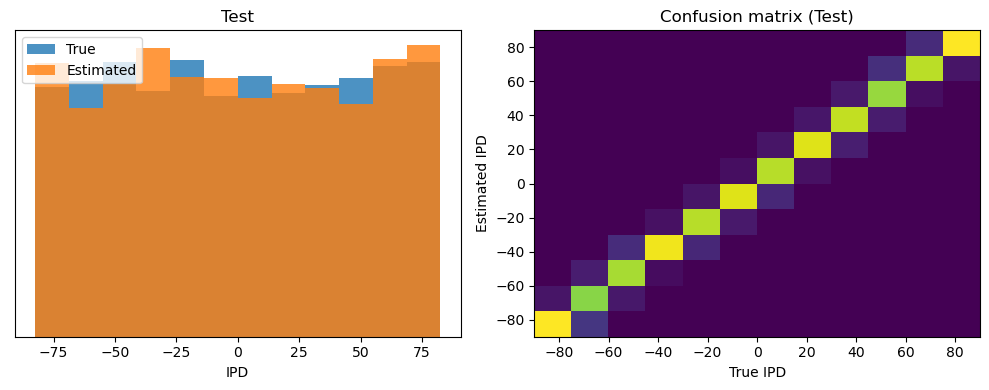

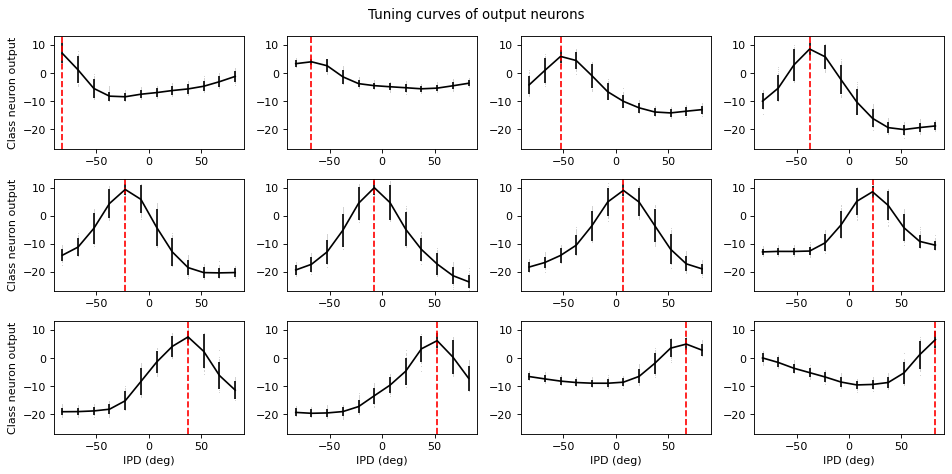

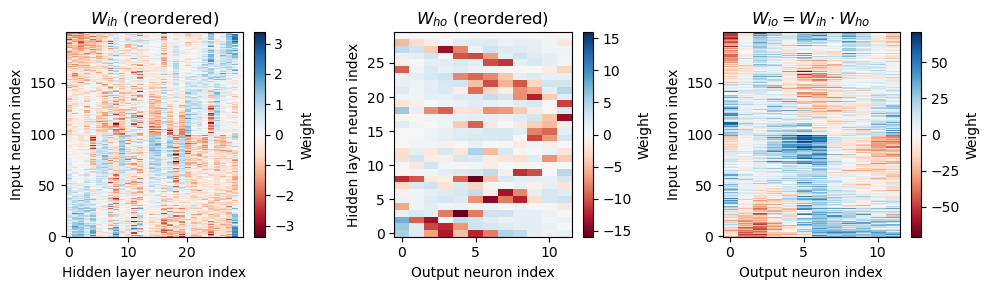

In [134]:
print(f"Chance accuracy level: {100/train_data.num_classes:.1f}%")
results_train = AnalysisResults(net, train_data, 'Train').print_text()
results_test = AnalysisResults(net, test_data, 'Test').print_text().visualise()

## Varying $\tau$

Below we systematically vary the membrane time constant $\tau$, saving results as we go, and then analyse the solutions found.

TODO:
* What happens when we reduce hidden neurons to 8 (which is how many tau=30ms needs)?
* Can we diagnose overfitting?
* Is there any structure in the weight matrices or tuning curves that depends on tau?
* I wonder if a possible conclusion we might reach is that the network needs more hidden neurons when tau is smaller but is more robust / better performance? Interesting biological conclusion.
* Can we figure out the strategy they're using?
* In the weight matrices below, the first half of the inputs are left ear, and the second half are right ear. That means that if one ear is largely negative and the other is largely positive, the network is doing a sort of ILD type computation? Which would be weird, but maybe suggests something is off in the stimulus generation if there are meaningful ILDs?
* We don't see a Jeffress-like strategy where there is a sharp peak in weights and hidden neurons only detect a single phase difference of coincidences.
* Other ideas are that it might just be using a mixed strategy, which if we could identify partial strategies we could quantify the mix.
* Need to remember that $W_{ih}$ is basically representing the distribution of ITD-sensitive cells (encoding strategy, compare to distribution of best delays) while $W_{ho}$ is representing the decoding strategy (compare to Jeffress versus pattern match versus hemispheric).
* Need to compute tuning curves for hidden neurons and compute distribution of best delays for comparison to literature.


### Run the simulations or load the saved data if available

  0%|          | 0/96 [00:00<?, ?it/s]

tau=1 ms
Accuracy on Train set = 89.7%, mean absolute error = 1.5 deg
Accuracy on Test set = 86.2%, mean absolute error = 2.1 deg
tau=2 ms
Accuracy on Train set = 90.3%, mean absolute error = 1.5 deg
Accuracy on Test set = 87.1%, mean absolute error = 1.9 deg
tau=5 ms
Accuracy on Train set = 88.4%, mean absolute error = 1.7 deg
Accuracy on Test set = 82.9%, mean absolute error = 2.6 deg
tau=10 ms
Accuracy on Train set = 86.3%, mean absolute error = 2.1 deg
Accuracy on Test set = 70.8%, mean absolute error = 4.4 deg
tau=15 ms
Accuracy on Train set = 74.4%, mean absolute error = 3.9 deg
Accuracy on Test set = 41.9%, mean absolute error = 40.1 deg
tau=20 ms
Accuracy on Train set = 81.9%, mean absolute error = 2.7 deg
Accuracy on Test set = 43.7%, mean absolute error = 10.4 deg
tau=25 ms
Accuracy on Train set = 79.4%, mean absolute error = 3.1 deg
Accuracy on Test set = 24.4%, mean absolute error = 61.2 deg
tau=30 ms
Accuracy on Train set = 77.3%, mean absolute error = 3.4 deg
Accuracy on 

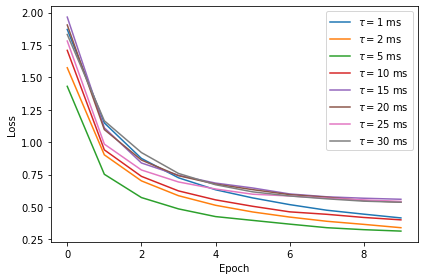

In [137]:
# # Quick run settings for debugging
# tau_range = [2, 20]
# nb_epochs = 10
# num_hidden = 30
# Long run settings for detailed analysis
tau_range = [1, 2, 5, 10, 15, 20, 25, 30]
nb_epochs = 10 # actually seems to just start overfitting after 10 epochs
num_hidden = 30
# Common
num_classes = train_data.num_classes
# Run the simulations or load the data if saved
if not os.path.exists('tempdata'):
    os.mkdir('tempdata')
pbar_steps = nb_epochs*len(tau_range)
nets = {}
results = {}
with tqdm(total=(nb_epochs+2)*len(tau_range)) as pbar:
    for tau in tau_range:
        fname = f'tempdata/itdnet_tau_{tau}_epochs_{nb_epochs}_hidden_{num_hidden}_classes_{num_classes}'
        if os.path.exists(fname+'.pt'):
            net = torch.load(fname+'.pt')
            loss_hist = np.load(fname+'_loss.npy')
            plt.plot(loss_hist, label=f'$\\{tau=}$ ms')
            pbar.update(nb_epochs)
            pbar.set_postfix(loaded=f'{tau=} ms')
        else:
            net = ITDNet(train_data, num_hidden=num_hidden, tau=tau*ms)
            loss_hist = np.array(net.train(nb_epochs=nb_epochs, pbar=pbar))
            np.save(fname+'_loss.npy', loss_hist)
            torch.save(net, fname+'.pt')
            # Plot the loss function over time
            plt.plot(loss_hist, label=f'$\\{tau=}$ ms')
        if os.path.exists(fname+'_results.pickle'):
            with open(fname+'_results.pickle', 'rb') as f:
                results_train, results_test = pickle.load(f)
            pbar.update(2)
            pbar.set_postfix(loaded_results=f'{tau=} ms')
        else:
            results_train = AnalysisResults(net, train_data, 'Train')
            pbar.update(1)
            pbar.set_postfix(results='train')
            results_test = AnalysisResults(net, test_data, 'Test')
            pbar.update(1)
            pbar.set_postfix(results='test')
            with open(fname+'_results.pickle', 'wb') as f:
                pickle.dump((results_train, results_test), f)
        results[tau, 'train'] = results_train
        results[tau, 'test'] = results_test
        print(f'{tau=} ms')
        results_train.print_text()
        results_test.print_text()
        nets[tau] = net
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.tight_layout()

### Analyse the results

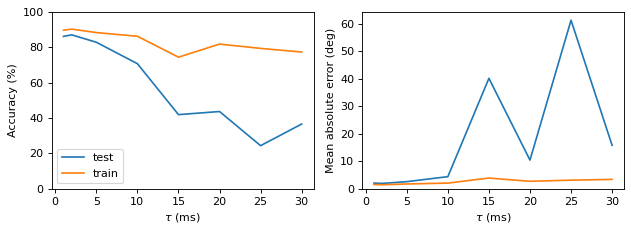

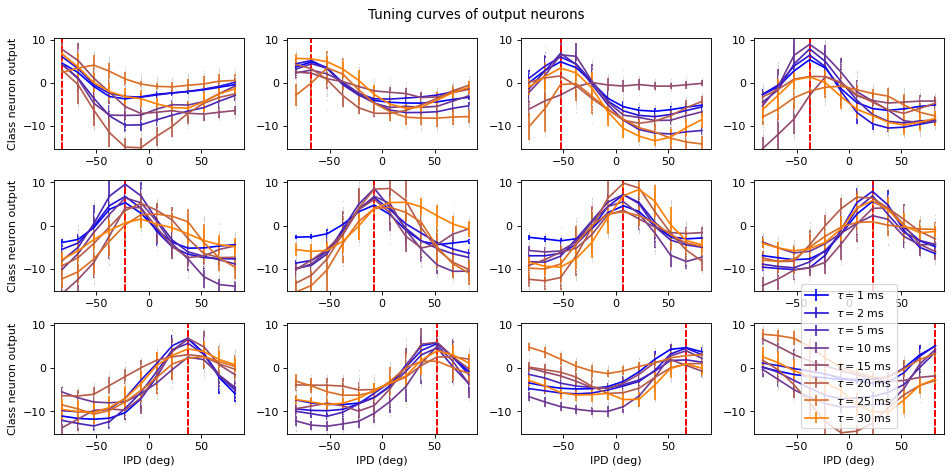

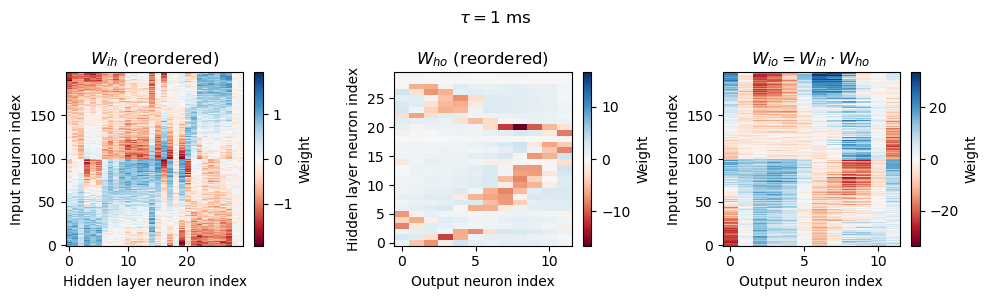

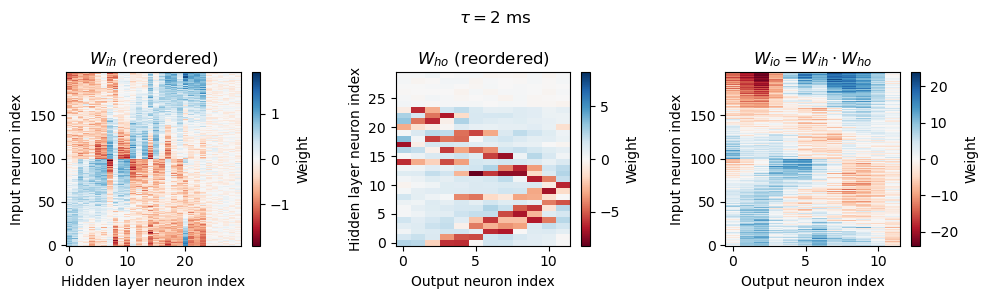

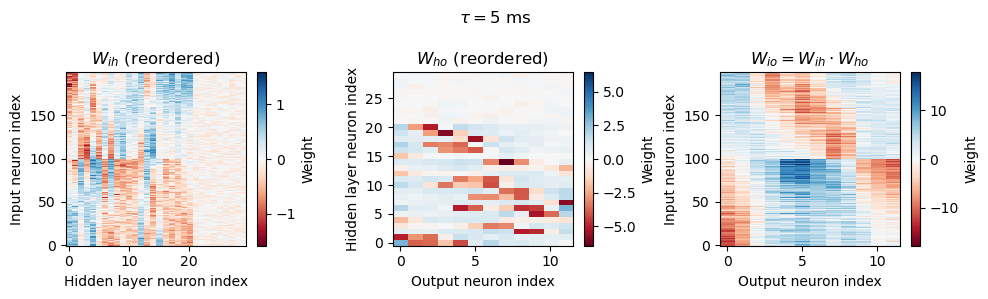

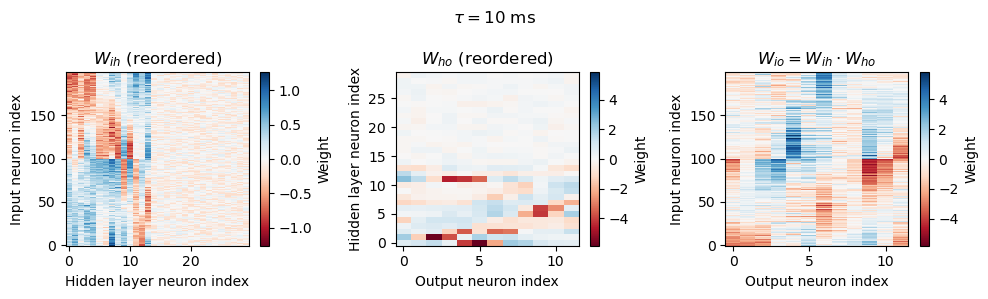

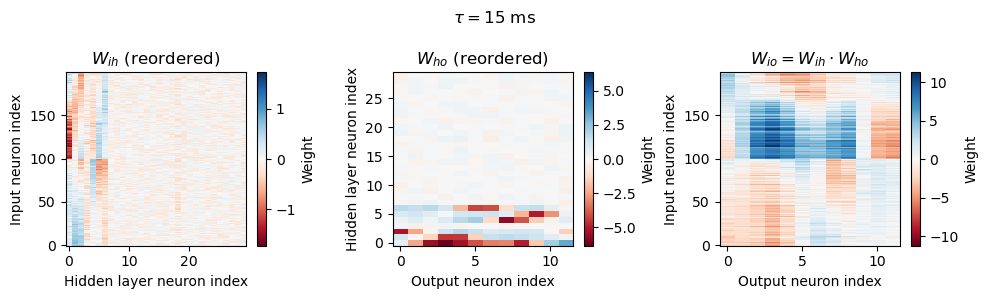

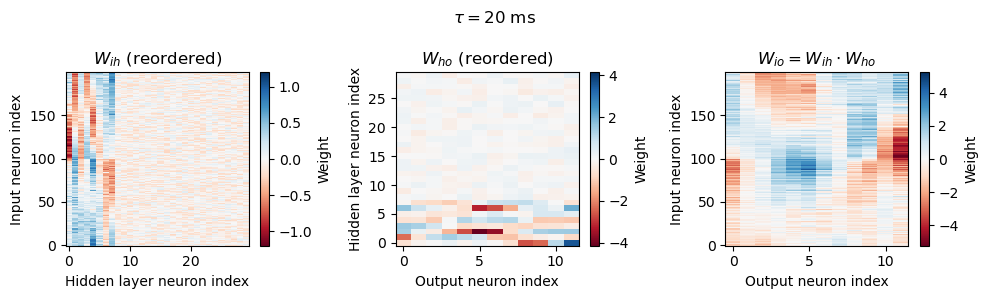

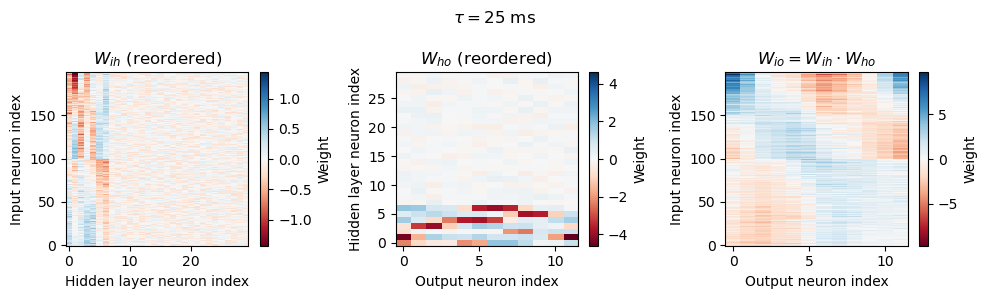

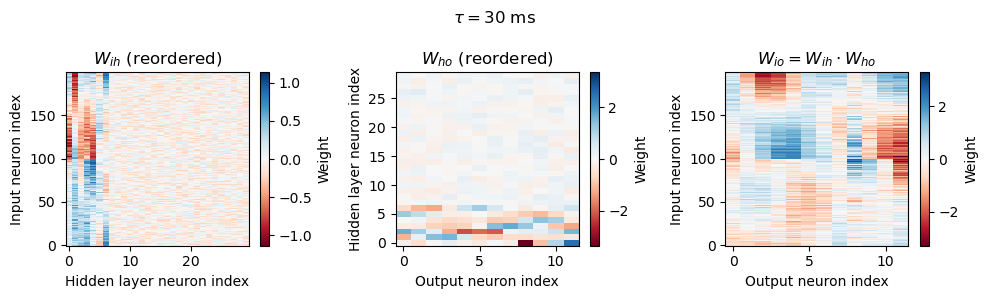

In [141]:
plt.figure(figsize=(8, 3), dpi=80)
plt.subplot(121)
for l in ['test', 'train']:
    plt.plot(tau_range, [100*results[tau, l].accuracy for tau in tau_range], label=l)
plt.legend(loc='best')
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.subplot(122)
for l in ['test', 'train']:
    plt.plot(tau_range, [results[tau, l].mean_abs_error_deg for tau in tau_range], label=l)
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel('Mean absolute error (deg)')
plt.ylim(ymin=0)
plt.tight_layout()

fig = plt.figure(figsize=(12, 6), dpi=80)
for i, tau in enumerate(tau_range):
    c = i/(len(tau_range)-1)
    c = (c, c/2, 1-c)
    results[tau, 'test'].plot_tuning_curves(fig=fig, c=c, label=f'$\\{tau=}$ ms')
plt.legend(loc='best')

for tau in tau_range:
    results[tau, 'test'].plot_weights()
    plt.suptitle(f'$\\{tau=}$ ms')
    plt.tight_layout()